#東京電力の需要予測

In [1]:
!pip3 install pystan #facebookが開発したprophetを使うのに必要
!pip3 install fbprophet #時系列は基本的にprophet

In [2]:
import pandas as pd
from fbprophet import Prophet

In [3]:
#_df=pd.read_csv("https://www.tepco.co.jp/forecast/html/images/juyo-2017.csv") #本来はファイルのパスを入れるが、URLでも可能
#↑ エラーが起きる 'utf-8' codec can't decode byte 0x8e in position 35: invalid start byte
#↓ encondingが違うという意味

_df=pd.read_csv("https://www.tepco.co.jp/forecast/html/images/juyo-2017.csv", encoding="shift-jis",skiprows=1) 
#skiprows=1 - 行を1つ飛ばして読み込み

In [4]:
print(_df.head())
print(_df.shape)
#日にちの1時間単位で情報が入っている

       DATE  TIME  実績(万kW)
0  2017/1/1  0:00     2783
1  2017/1/1  1:00     2634
2  2017/1/1  2:00     2520
3  2017/1/1  3:00     2438
4  2017/1/1  4:00     2389
(8760, 3)


In [5]:
# それぞれの年度で読み込み
years = [2017,2018,2019]

# year = years[0] #0=2017, 1=2018, 2=2019で年度のデータを読み込める

df=pd.DataFrame() #空のデータフレーム
for year in years: 
    _df=pd.read_csv(f"https://www.tepco.co.jp/forecast/html/images/juyo-{year}.csv", encoding="shift-jis",skiprows=1) 
    df = pd.concat([df,_df],axis=0) #空のもの(df)に対して2017年のもの(_df)をくっつけてconcat(concatenate(連結))する, axis=0行方向に結合する, 新しいpandasが生成されるだけのなのでなのでdfに上書きする
print(df)

#これで2017~2019年のデータが入ったことを確認できる

            DATE   TIME  実績(万kW)
0       2017/1/1   0:00     2783
1       2017/1/1   1:00     2634
2       2017/1/1   2:00     2520
3       2017/1/1   3:00     2438
4       2017/1/1   4:00     2389
...          ...    ...      ...
8755  2019/12/31  19:00     3302
8756  2019/12/31  20:00     3263
8757  2019/12/31  21:00     3182
8758  2019/12/31  22:00     3077
8759  2019/12/31  23:00     3029

[26280 rows x 3 columns]


#データの前処理

In [6]:
#インデックスのリセット - そのままconcantしたためindexがそのまま適用されたので(0,1,2,,,,が3つづつある)重なっているもとのindexを削除して新しくindexを添付する
df = df.reset_index(drop=True) 

In [7]:
# fbprophetを使うためには2つのカラムを使う必要がある
# 1,日付を用意するdsカラム
# 2,yカラム　= 今回求めたい実績

# DATEとTIMEが別れているがDATETIMEの合わさったデータが欲しい
# DATEとTIMEをdatetimeオブジェクトに格納

date = df["DATE"][0]
time = df["TIME"][0] 
str_datetime = f"{date} {time}" #文字列で定義
print(str_datetime)

2017/1/1 0:00


In [8]:
# datetimeオブジェクトに変換
from datetime import datetime as dt

# 文字列をdatetime型にformatを変換
datetime = dt.strptime(str_datetime, "%Y/%m/%d %H:%M") #"%Y(ear)/%m(onth)/%d(ay) %H(our):%M(inute)"は2017/1/1 0:00と同じ形 
# ↑ DATEとTIMEをdatetimeオブジェクトに格納成功

In [9]:
#for文で全て変換
datetimes = [] #変換をしたものを空のリストに追加

for index, datum in df.iterrows(): #indexとdatum(中身)を持ってきてくれる
    date = datum["DATE"]
    time = datum["TIME"] 
    str_datetime = f"{date} {time}"
    datetime = dt.strptime(str_datetime, "%Y/%m/%d %H:%M") 
    datetimes.append(datetime)

In [10]:
datetimes[:3] #量が多いので先頭3行のみ

[datetime.datetime(2017, 1, 1, 0, 0),
 datetime.datetime(2017, 1, 1, 1, 0),
 datetime.datetime(2017, 1, 1, 2, 0)]

In [11]:
df["ds"] = datetimes #リストをdsというカラムに入れてあげる

In [12]:
df.head()

,DATE,TIME,実績(万kW),ds
0,2017/1/1,0:00,2783,2017-01-01 00:00:00
1,2017/1/1,1:00,2634,2017-01-01 01:00:00
2,2017/1/1,2:00,2520,2017-01-01 02:00:00
3,2017/1/1,3:00,2438,2017-01-01 03:00:00
4,2017/1/1,4:00,2389,2017-01-01 04:00:00


In [13]:
# 実績(目標値)をyというカラム名に変更する
df = df.rename(columns={"実績(万kW)":"y"})
df.head()

,DATE,TIME,y,ds
0,2017/1/1,0:00,2783,2017-01-01 00:00:00
1,2017/1/1,1:00,2634,2017-01-01 01:00:00
2,2017/1/1,2:00,2520,2017-01-01 02:00:00
3,2017/1/1,3:00,2438,2017-01-01 03:00:00
4,2017/1/1,4:00,2389,2017-01-01 04:00:00


#予測モデルの構築

In [14]:
# prophetはscikit learnとほぼ同じ(scikit learn based)
model = Prophet() #アルゴリズムの定義
model.fit(df) #データ(df:2017~2019)を与えて学習

In [15]:
# どのような需要予測が可能なのかをみるために未来のデータを準備する
future = model.make_future_dataframe(24*366,freq="H") #2020を予測してたい場合2020年分の空のデータフレームを作る必要がある
# 24*366は2022年は閏年のため24時間の366日分のデータを準備する
# freq=頻度(今回は時間単位"H" = １時間単位)

future.tail() #2020年のデータが入っていることを確認できる(データ数が増えている#)
# これでdsしかない(時間軸しか用意されていない)データフレームを作れた

,ds
35059,2020-12-31 19:00:00
35060,2020-12-31 20:00:00
35061,2020-12-31 21:00:00
35062,2020-12-31 22:00:00
35063,2020-12-31 23:00:00


In [16]:
# 実際に予想してみる
forcast = model.predict(future) #futureは空だが左部分に予測値をいれる

In [17]:
# forcastを可視化する↓
import matplotlib.pyplot as plt

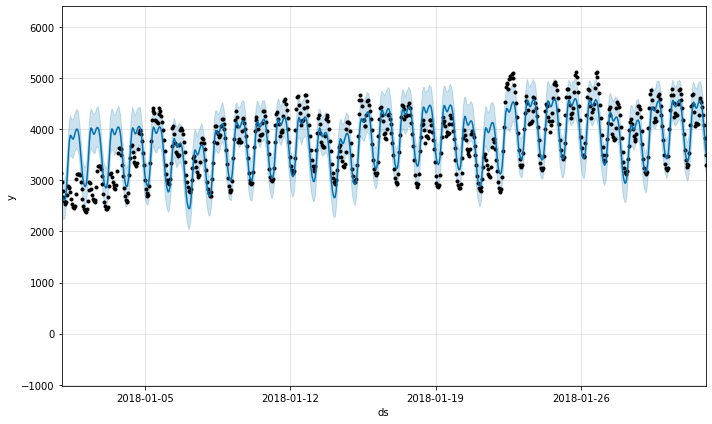

In [18]:
model.plot(forcast)
plt.xlim(dt(2018,1,1),dt(2018,2,1))  #範囲を狭める,(2018,1,1)から(2018,2,1)の間
plt.show()

#比較的周期性のあるように見える
# 青が予測線
# 黒が実測値
# おおむね外れていないので問題がない(桁外れの間違いがない)
# 2020年の実測値と予測値がどれくらい離れているのか確認するのが重要

#予測結果の集約(実測値と予測値を求める)

In [19]:
df_2020=pd.read_csv("https://www.tepco.co.jp/forecast/html/images/juyo-2020.csv", encoding="shift-jis",skiprows=1) 

In [20]:
df_2020.head() #2020年のデータを求めることができた

,DATE,TIME,実績(万kW)
0,2020/1/1,0:00,2857
1,2020/1/1,1:00,2703
2,2020/1/1,2:00,2602
3,2020/1/1,3:00,2520
4,2020/1/1,4:00,2464


In [21]:
# 予測結果の中の日付が2020年1月1日以降のものを取得する, 条件付きデータ取得
forcast_2020 = forcast[forcast["ds"] >= dt(2020,1,1)].reset_index(drop=True) #2020,1,1より先のデータ(forcast["ds"])という条件式をforcastで囲ってみる
# reset_index(drop=True) -> indexを0から始める
# 2020年1月１日以降のデータのみをピックアップできる
forcast_2020.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01 00:00:00,3134.340011,2517.300656,3283.552231,3134.340011,3134.340011,-224.856836,-224.856836,-224.856836,-488.417802,...,108.739814,108.739814,108.739814,154.821152,154.821152,154.821152,0.0,0.0,0.0,2909.483175
1,2020-01-01 01:00:00,3134.297635,2411.292439,3156.945685,3134.297635,3134.297635,-354.546087,-354.546087,-354.546087,-617.309962,...,108.086395,108.086395,108.086395,154.677480,154.677480,154.677480,0.0,0.0,0.0,2779.751548
2,2020-01-01 02:00:00,3134.255259,2319.354026,3093.619935,3134.255259,3134.255259,-432.164816,-432.164816,-432.164816,-694.375983,...,107.671307,107.671307,107.671307,154.539860,154.539860,154.539860,0.0,0.0,0.0,2702.090443
3,2020-01-01 03:00:00,3134.212883,2305.802430,3081.100157,3134.212883,3134.212883,-466.064530,-466.064530,-466.064530,-727.960893,...,107.488055,107.488055,107.488055,154.408308,154.408308,154.408308,0.0,0.0,0.0,2668.148353
4,2020-01-01 04:00:00,3134.170507,2293.434058,3061.490403,3134.170507,3134.170507,-446.333967,-446.333967,-446.333967,-708.142983,...,107.526173,107.526173,107.526173,154.282843,154.282843,154.282843,0.0,0.0,0.0,2687.836539


In [22]:
df_2020 = df_2020.rename(columns={"実績(万kW)":"y"}) #名前の変更, y=実測値
df_2020.head()

,DATE,TIME,y
0,2020/1/1,0:00,2857
1,2020/1/1,1:00,2703
2,2020/1/1,2:00,2602
3,2020/1/1,3:00,2520
4,2020/1/1,4:00,2464


In [23]:
forcast_2020["yhat"] #"yhat"=予測値(推定値)

0       2909.483175
1       2779.751548
2       2702.090443
3       2668.148353
4       2687.836539
           ...     
8779    3432.955979
8780    3329.200745
8781    3163.596655
8782    2952.388022
8783    2734.208687
Name: yhat, Length: 8784, dtype: float64

In [24]:
results = pd.DataFrame() #空で準備 

#df_2020["y"]は実測値が入っている
results["t"] = df_2020["y"] 

#df_2020["y"]は予測値が入っている
results["y"] = forcast_2020["yhat"] 

#tと書いたらy, yと書いたらyhatになる

# 引き算をする(実測値の予測値差を見たい,差分を取って具体的な差分を見る)
results["diff"] = results["t"] - results["y"]
results.head()

# 実測値t,予測値y,２つの引き算のdiffが取れる
# 差分の単位は万キロワット

,t,y,diff
0,2857,2909.483175,-52.483175
1,2703,2779.751548,-76.751548
2,2602,2702.090443,-100.090443
3,2520,2668.148353,-148.148353
4,2464,2687.836539,-223.836539


#評価指標(MAPE) - 予測結果が良かったのか評価する

In [25]:
# 一般的に用いられている評価指標
# MSE(Mean Squared Error) - 平均二乗誤差
# RMSE(Root Mean Squared Error) - 平均平方二乗誤差

# これらは数値のスケールが大きくなればなるほど結局誤差が大きいのか、小さいのか判断がつきにくい
# ↓MAPE(Mean Absolute Percent Error:絶対誤差)の式,割合を見る

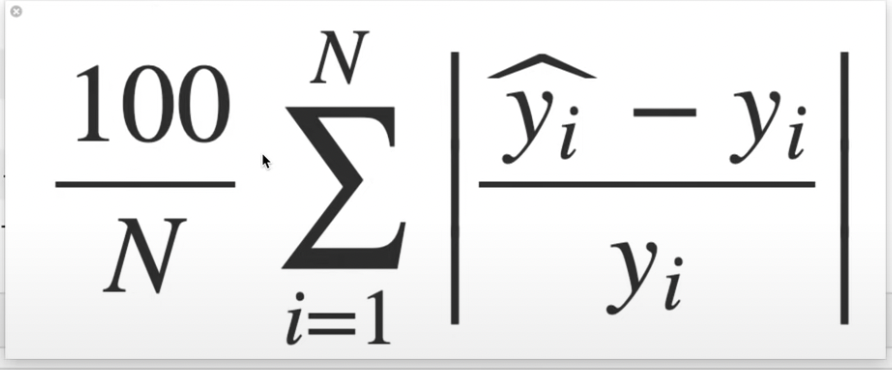

In [26]:
# MAPEの実装
import numpy as np

In [27]:
# MAPEの式
np.mean(abs((results["y"] - results["t"]) / results["t"])*100)

# 11.602725141191982 -  実際の値から11%くらい全体から離れている,%で誤差を表現した 

10.123644353466581

#精度向上のための施策(データに追加休日,猛暑日を入れてみる)

In [45]:
df_holidays = pd.read_csv("holidays+hotdays+hour_2017_2019.csv",) #-> 2017~2019年のデータ
df_holidays.head() #upperwindの0と１の違い(1は次の日に影響を与える,一日分影響を与えるかもしない(例:クリスマスイブはクリスマスに影響を与える))

,ds,holiday,lower_window,upper_window
0,2017/01/01 0:00:00,holiday,0,1
1,2017/01/01 1:00:00,holiday,0,1
2,2017/01/01 10:00:00,holiday,0,1
3,2017/01/01 11:00:00,holiday,0,1
4,2017/01/01 12:00:00,holiday,0,1


In [29]:
#cap(capacity(上限))を設定する必要がある
df.y.max() #yの最大(上限)

5653

In [30]:
df["cap"] = 5700 # cap = 推測値を指定している
df.head() #capが追加された

,DATE,TIME,y,ds,cap
0,2017/1/1,0:00,2783,2017-01-01 00:00:00,5700
1,2017/1/1,1:00,2634,2017-01-01 01:00:00,5700
2,2017/1/1,2:00,2520,2017-01-01 02:00:00,5700
3,2017/1/1,3:00,2438,2017-01-01 03:00:00,5700
4,2017/1/1,4:00,2389,2017-01-01 04:00:00,5700


In [37]:
type(df_holidays)

pandas.core.frame.DataFrame

In [61]:
# event性(祝日,猛暑)などを考慮してモデルを作
model = Prophet(
    growth="logistic",
    yearly_seasonality=True, #周期性を全部Trueにする
    weekly_seasonality=True,
    daily_seasonality=True,
    holidays = None #本当はdf_holidaysにしたいがエラーが出るためNoneにした
    )

In [48]:
model.fit(df)

In [49]:
future["cap"] = 5700

In [51]:
forecast = model.predict(future)

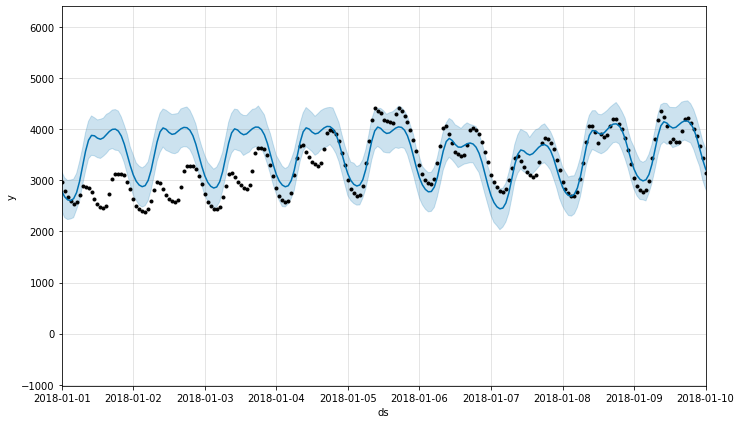

In [54]:
model.plot(forcast)
plt.xlim(dt(2018,1,1),dt(2018,1,10))
plt.show()

In [55]:
forcast_2020 = forcast[forcast["ds"] >= dt(2020,1,1)].reset_index(drop=True) 

In [56]:
#df_2020["y"]は実測値が入っている
results["t"] = df_2020["y"] 

#df_2020["y"]は予測値が入っている
results["y"] = forcast_2020["yhat"] 
results["diff"] = results["t"] - results["y"]

results.head()

,t,y,diff
0,2857,2909.483175,-52.483175
1,2703,2779.751548,-76.751548
2,2602,2702.090443,-100.090443
3,2520,2668.148353,-148.148353
4,2464,2687.836539,-223.836539


In [57]:
np.mean(abs((results["y"] - results["t"]) / results["t"])*100)
#↓の結果 祝日のデータが抜けてしまったため精度に変化がない

10.123644353466581

#周期性の確認

TypeError: ignored

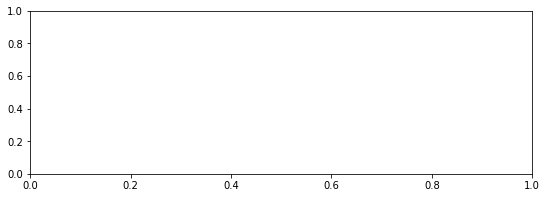

In [64]:
model.plot_components(forecast) #周期性を確認できる,今回はエラーが起きた,おそらくholidayがないから
plt.show()